# Manchester Corpus

In [1]:

import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from dataset import get_manchester

plt.rcParams['figure.figsize'] = 15, 5

unigrams, bigrams, trigrams = get_manchester(
    "/home/paul/corpora/Manchester/**/*", 
    cached=True, 
    gram_sizes=[1,2,3])
unigrams['part'] = np.where(unigrams.filename.str.contains(r'a\.xml'), 'a', 'b')
unigrams['fullsession'] = unigrams.session.astype(str) + unigrams.part

mot_or_child = unigrams.speaker.isin(['MOT', 'CHI'])

def per_session_plot(title):
    plt.grid()
    plt.xticks(np.arange(1,35))
    plt.title(title)
    plt.legend()
    plt.show()

# Children with missing files

A full corpus contains 68 files (34 sessions, one file for each of part a and part b)

In [3]:
x = (unigrams
    .groupby('corpus')
    .filename
    .nunique()
)
x[x < 68].sub(68).abs().pipe(pd.DataFrame).rename(columns={'filename': 'number of files missing'})

,number of files missing
corpus,
aran,2
carl,3
john,4
ruth,2
warr,1


# Words per child

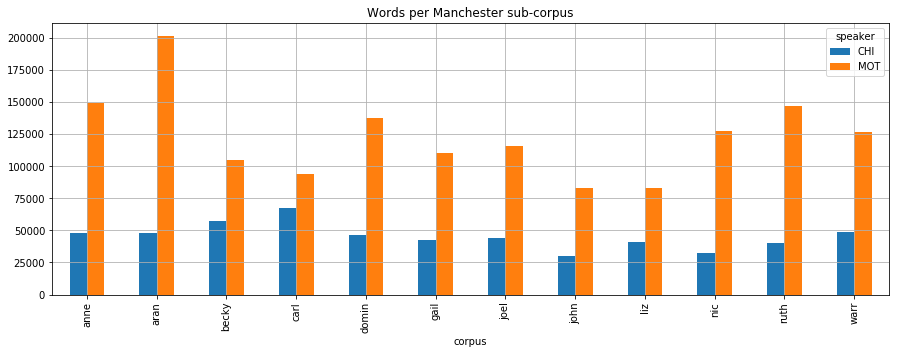

In [4]:
(
    unigrams
    [mot_or_child]
    .groupby(['corpus', 'speaker'])
    .ngram
    .count()
).unstack().plot.bar(title="Words per Manchester sub-corpus", grid=True);

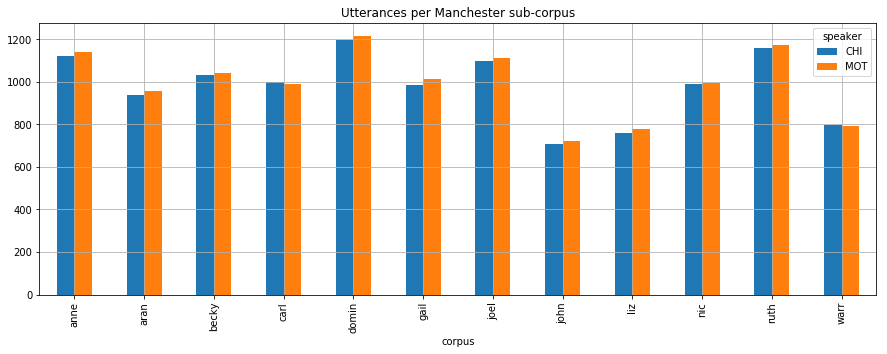

In [5]:
(
    unigrams
    [mot_or_child]
    .groupby(['corpus', 'speaker'])
    .uid
    .nunique()
).unstack().plot.bar(title='Utterances per Manchester sub-corpus', grid=True);

# Words per session

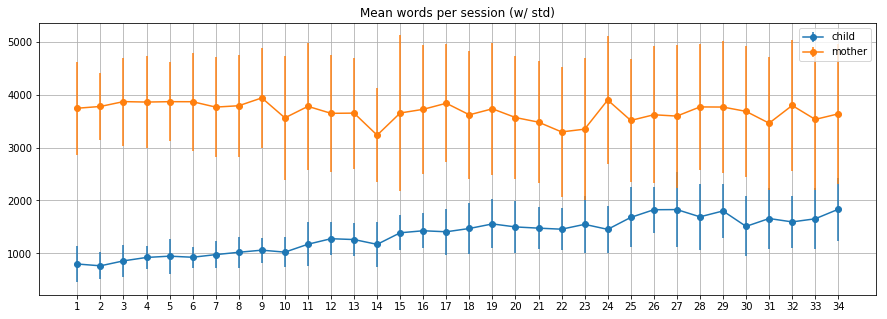

In [6]:
word_count = (unigrams
    [mot_or_child]
    .groupby('corpus session speaker'.split())
    .size()
              
    .groupby(['speaker', 'session'])
    .agg([np.mean, np.std])
)

d = word_count.loc['CHI']
plt.errorbar(d.index, d['mean'], d['std'], label='child', marker='o')

d = word_count.loc['MOT']
plt.errorbar(d.index, d['mean'], d['std'], label='mother', marker='o')

per_session_plot('Mean words per session (w/ std)')

# Utterances per session

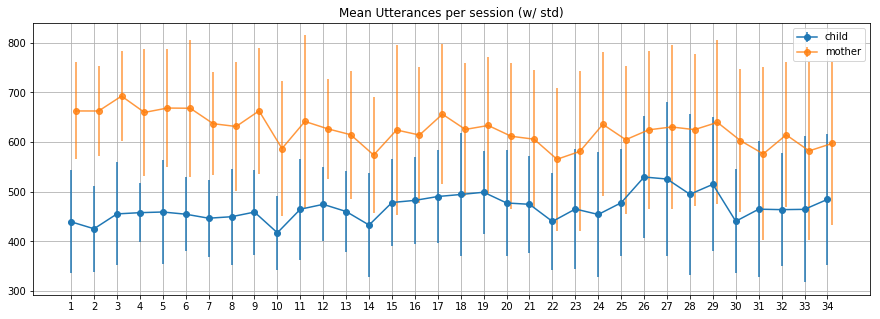

In [7]:
utterance_count = (unigrams
    [mot_or_child]
    .groupby('corpus session speaker'.split())
    .uid
    .nunique()
    .groupby(['speaker', 'session'])
    .agg([np.mean, np.std])
)

d = utterance_count.loc['CHI']
plt.errorbar(d.index, d['mean'], d['std'], label='child', marker='o')

d = utterance_count.loc['MOT']
plt.errorbar([x+0.2 for x in d.index], d['mean'], d['std'], label='mother', marker='o', alpha=0.8)

per_session_plot('Mean Utterances per session (w/ std)')

# Number of types observed per session

aka size of vocab per session

In [8]:
vocab = (
    unigrams[mot_or_child]
    .groupby(['speaker', 'corpus', 'session'])
    .ngram
    .nunique()
)
#vocab.unstack().T.plot(title='Number of types observed within a session');

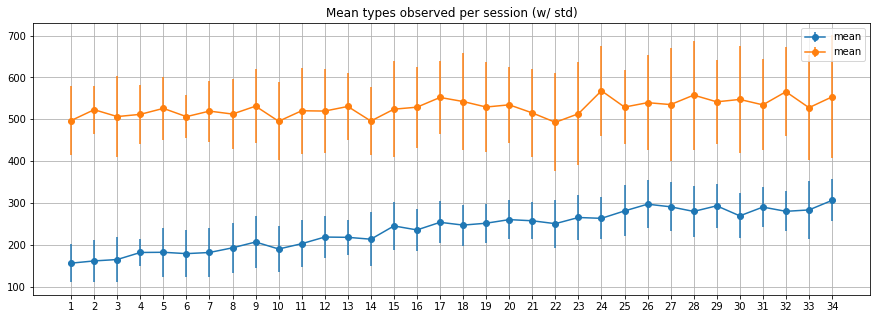

In [9]:
vocab = (
    unigrams[mot_or_child]
    .groupby(['speaker', 'corpus', 'session'])
    .ngram
    .nunique()
    .groupby(level=['speaker', 'session'])
    .agg(['mean', 'std'])
)
for speaker in 'CHI MOT'.split():
    plt.errorbar(vocab.loc[speaker].index, vocab.loc[speaker]['mean'], vocab.loc[speaker]['std'], marker='o')
per_session_plot('Mean types observed per session (w/ std)')

/home/paul/.virtualenvs/formulae/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


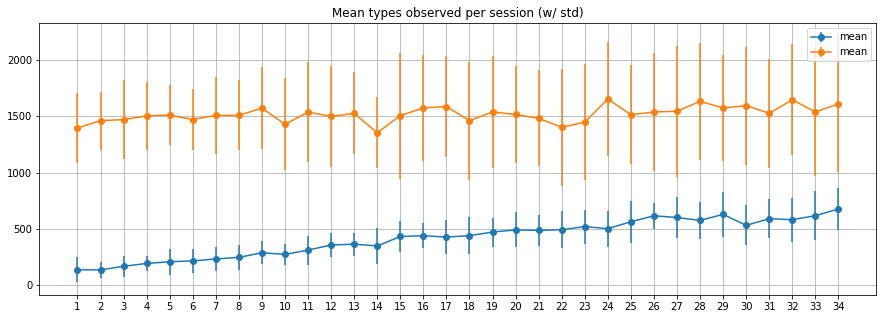

In [11]:
vocab = (
    bigrams[mot_or_child]
    .groupby(['speaker', 'corpus', 'session'])
    .ngram
    .nunique()
    .groupby(level=['speaker', 'session'])
    .agg(['mean', 'std'])
)
for speaker in 'CHI MOT'.split():
    plt.errorbar(vocab.loc[speaker].index, vocab.loc[speaker]['mean'], vocab.loc[speaker]['std'], marker='o')
per_session_plot('Mean bigram types observed per session (w/ std)')

/home/paul/.virtualenvs/formulae/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


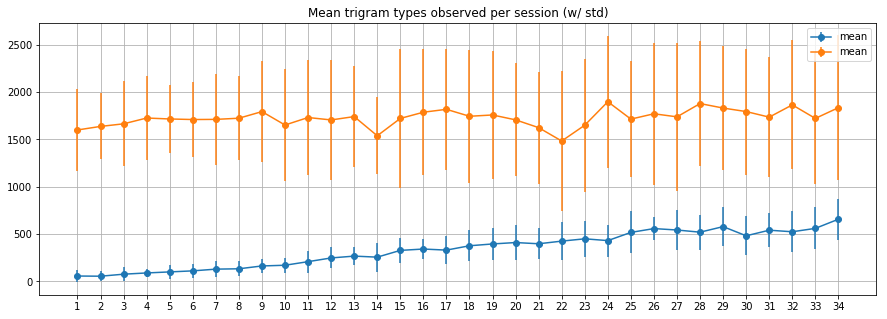

In [13]:
vocab = (
    trigrams[mot_or_child]
    .groupby(['speaker', 'corpus', 'session'])
    .ngram
    .nunique()
    .groupby(level=['speaker', 'session'])
    .agg(['mean', 'std'])
)
for speaker in 'CHI MOT'.split():
    plt.errorbar(vocab.loc[speaker].index, vocab.loc[speaker]['mean'], vocab.loc[speaker]['std'], marker='o')
per_session_plot('Mean trigram types observed per session (w/ std)')

# Vocabulary Growth

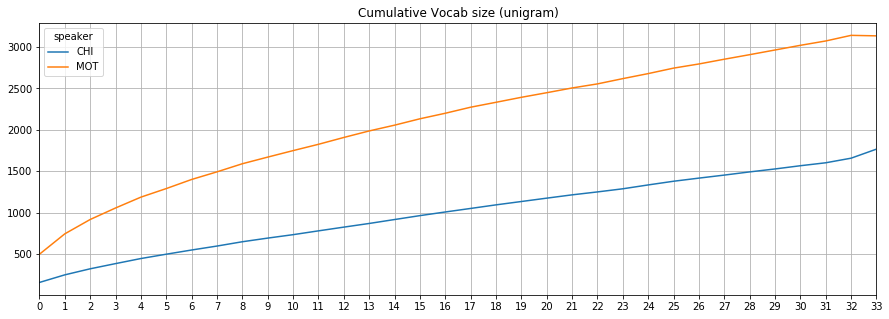

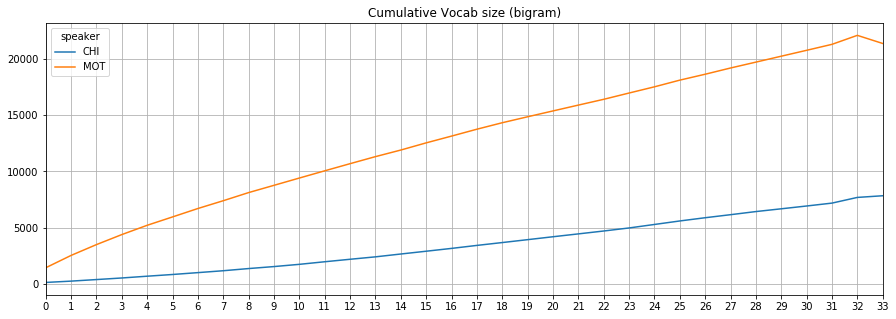

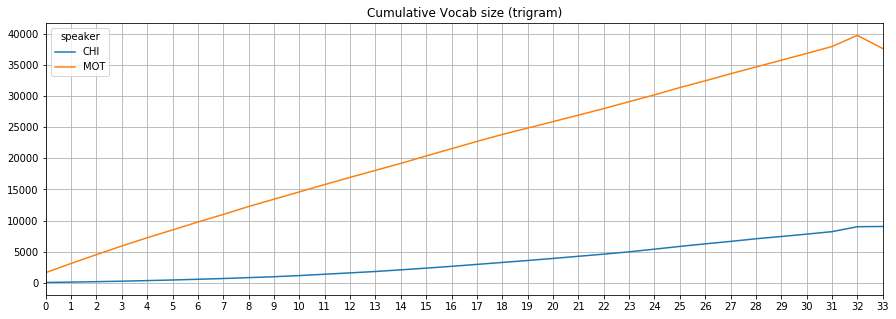

In [10]:
from itertools import accumulate

def cumulative_type_count(per_session_types):
    return [len(x) 
            for x in accumulate(per_session_types, 
                                lambda acc, x: set(acc).union(x))]

for name, dataset in {'uni': unigrams, 'bi': bigrams, 'tri': trigrams}.items():
    cumvoc = (dataset
     [dataset.speaker.isin(['MOT', 'CHI'])]
     .groupby(['corpus', 'speaker', 'session'])
     .ngram
     .unique()
     .groupby(level=['corpus', 'speaker'])
     .apply(lambda x: pd.Series(cumulative_type_count(x)))
     .unstack()
    )
    cumvoc.groupby(level='speaker').mean().T.plot(title='Cumulative Vocab size ({}gram)'.format(name), 
                                                  xticks=np.arange(0,34), 
                                                  grid=True);